In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [9]:
import random


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
C = torch.randn((27, 2))

In [11]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [13]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [14]:
h

tensor([[ 0.9453, -0.8882, -0.9376,  ...,  0.9899, -0.9977, -0.9697],
        [-0.0345,  0.6566,  0.2202,  ...,  0.2966, -0.3383,  0.8211],
        [ 0.7269,  0.9769, -0.8946,  ...,  0.7519, -0.9994,  0.3405],
        ...,
        [-0.3607, -0.7867, -0.9832,  ...,  0.8775, -0.9992, -0.6728],
        [-0.9945, -0.2316,  0.1008,  ...,  0.9338,  0.9535,  0.9397],
        [ 0.9843, -0.3680, -0.9004,  ..., -0.9795, -0.9999, -0.3991]])

In [15]:
h.shape

torch.Size([228146, 100])

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([228146, 27])

In [19]:
counts = logits.exp()

In [20]:
prob = counts / counts.sum(1, keepdim=True)

In [21]:
prob.shape

torch.Size([228146, 27])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [25]:
# ------------------- Main Code ----------------------------

In [23]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [24]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [25]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [26]:
for p in parameters:
    p.requires_grad = True

In [27]:
lre = torch.linspace(-3, 0, 1000) # for choose an appropriate learning rate
lrs = 10**lre

In [28]:
lri = []
lossi = []
stepi = []

In [29]:
Xtr.shape

torch.Size([182625, 3])

In [32]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

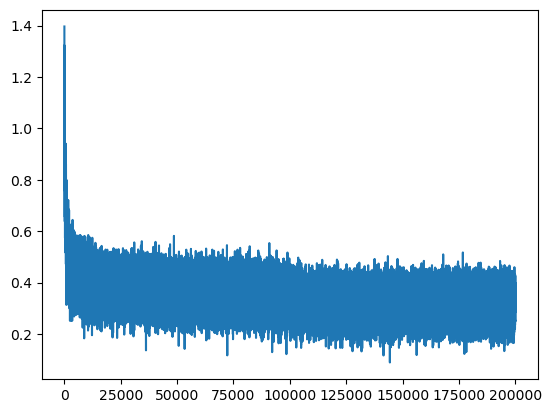

In [33]:
plt.plot(stepi, lossi)

In [34]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1293, grad_fn=<NllLossBackward0>)

In [35]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1742, grad_fn=<NllLossBackward0>)

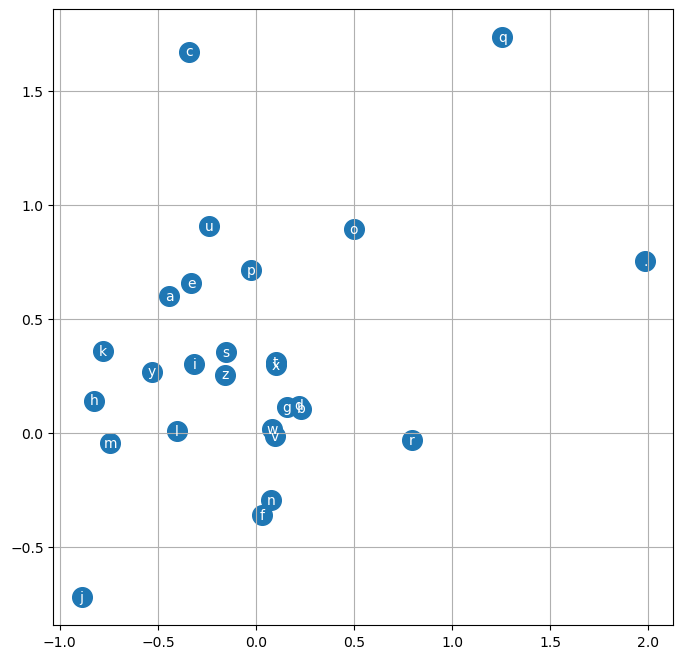

In [36]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [39]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [41]:
C[torch.tensor([context])].view(1, -1).shape

torch.Size([1, 30])

In [43]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

montalmyanniellend.
ryla.
remmasiendraege.
zeredielin.
shi.
jen.
edenson.
anar.
kayzion.
kalin.
shubergshiriel.
kendreelynn.
novana.
ummethen.
jamell.
elsyn.
ajayson.
amihaan.
alynn.
julzamelle.
